In [37]:
from jupyter_client import find_connection_file

connection_file = find_connection_file()
# print(connection_file)

In [38]:
# Plotting related
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


# Scikit-learn related imports
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.options.mode.copy_on_write = True

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.linear_model import LogisticRegression

# Jupyter-related
from IPython.display import Markdown as md

In [39]:
# Change the current working directory
os.chdir("/home/yonatan/Documents/projects/vaccines/code")
# maybe make plotly work
pio.renderers.default = "notebook"

In [40]:
dataset_col = "Dataset"
uid_col = "uid"
age_col = "Age"
day_col = "Day"
response_col = "Response"
immage_col = "IMMAGE"
strain_col = "Strain"

In [41]:
def get_data_dir():
    # Define the starting directory
    current_dir = os.getcwd()

    # Traverse up the directory tree until we find a directory named "data"
    while current_dir != "/":
        if "data" in os.listdir(current_dir):
            data_dir = os.path.join(current_dir, "data")
            return data_dir
        current_dir = os.path.dirname(current_dir)
    else:
        print("Directory 'data' not found in the parent directories.")
        raise ()

In [42]:
# Read in Data and drop missing values
data_dir = get_data_dir()
df = pd.read_csv(os.path.join(data_dir, "../data/all_vaccines.csv"))
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])

dataset_names = df.Dataset.unique()
datasets = df

#### Distribution of studies' N values

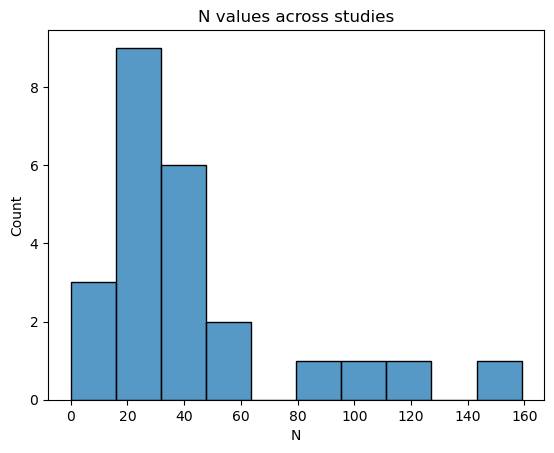

In [43]:
# Plot distribution of N values
N_vals = df[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
sns.histplot(N_vals.N)
plt.title("N values across studies")
plt.show()

In [60]:
dataset = df.loc[df[dataset_col].str.contains("GSE59654")]
# dataset.loc[dataset["Vaccine"] != "Menactra"][uid_col].unique().__len__()
for dataset, group in dataset.groupby('Dataset'):
    print(f"Dataset: {dataset}")
    print("Unique UID values:")
    print(group['uid'].unique())
    print()

Dataset: GSE59654.SDY180
Unique UID values:
['SUB119262.180' 'SUB119267.180' 'SUB119268.180' 'SUB119274.180'
 'SUB119277.180' 'SUB119278.180' 'SUB119281.180' 'SUB119285.180'
 'SUB119286.180' 'SUB119287.180' 'SUB119289.180' 'SUB119290.180'
 'SUB119292.180' 'SUB119293.180' 'SUB119294.180' 'SUB119295.180'
 'SUB119296.180' 'SUB119297.180']

Dataset: GSE59654.SDY404
Unique UID values:
['SUB120418.404' 'SUB120420.404' 'SUB120421.404' 'SUB120422.404'
 'SUB120424.404' 'SUB120425.404' 'SUB120427.404' 'SUB120428.404'
 'SUB120430.404' 'SUB120435.404' 'SUB120436.404' 'SUB120437.404'
 'SUB120440.404' 'SUB120441.404' 'SUB120442.404' 'SUB120445.404'
 'SUB120446.404' 'SUB120450.404' 'SUB120452.404' 'SUB120457.404'
 'SUB120458.404' 'SUB120459.404' 'SUB120460.404' 'SUB120462.404'
 'SUB120466.404' 'SUB120467.404' 'SUB120469.404' 'SUB120470.404'
 'SUB120472.404' 'SUB120473.404' 'SUB120474.404' 'SUB120479.404'
 'SUB120480.404' 'SUB120481.404' 'SUB120483.404' 'SUB120484.404'
 'SUB120485.404' 'SUB120487.404'

#### Narrow to large datasets only (N > 70)

In [ ]:
# Narrow N_v to large datasets only
bNarrow = False
N_vals = N_vals.loc[N_vals["N"] > 70]
if bNarrow:
    datasets = df.loc[df["Dataset"].isin(N_vals["Dataset"])]
dataset_names = datasets["Dataset"].unique()
# print(N_vals)

In [ ]:
# Examine available days per dataset
days = (
    datasets[[dataset_col, uid_col, day_col]].groupby(dataset_col, as_index=False)[day_col].unique()
)
# with pd.option_context('display.max_colwidth', None):
for index, row in days.iterrows():
    print(f"\"{row['Dataset']}\": {row['Day']}")

In [ ]:
# Collect day info from papers here
dataset_day_dict = {}

dataset_day_dict["GSE41080.SDY212"] = "HAI.D28"
dataset_day_dict["GSE48018.SDY1276"] = "nAb.D28"
dataset_day_dict["GSE48023.SDY1276"] = "nAb.D28"
dataset_day_dict["SDY67"] = "nAb.D28"
# dataset_day_dict[dataset_names[0]]

In [ ]:
# Narrow to a specific dataset and day, then keep only relevant columns
strain_index = 0
dataset_name = dataset_names[0]

#### Narrow to a specific dataset and day, then keep only relevant columns

In [ ]:
# Narrow to a specific dataset and day, then keep only relevant columns
strain_index = 0
dataset_name = dataset_names[0]

In [ ]:
name_mask = datasets[dataset_col] == dataset_name
day_mask = datasets[day_col] == dataset_day_dict[dataset_name]

data = datasets.loc[(name_mask) & (day_mask)].reset_index()

# Somtimes there are multiple strains - so multiple rows per day
strains = data[strain_col].unique()
if len(strains) > 1:
    data = data.loc[data[strain_col] == strains[strain_index]].reset_index()

strains_t = data[strain_col].unique()
assert len(strains_t) == 1
strain = strains_t[0]

# Sometimes there are multiple geo_accession numbers, like in GSE48018.SDY1276, average the IMMAGE, since all else is the same
accessions = data["geo_accession"].unique()
if len(accessions) > 1:
    # print(f"*** Multiple accession detected! Collapsing by averaging on IMMAGE value ***\n")
    data = data.groupby(uid_col, as_index=False).agg(
        {
            immage_col: "mean",
            **{col: "first" for col in data.columns if col not in [uid_col, immage_col]},
        }
    )

# Take relevant columns only
data = data[[immage_col, response_col, age_col]]

#### Dataset & Strain info

In [ ]:
md(f'''Working with dataset: {dataset_name}, strain: {strain}\n
Total subjects in study: N={data.shape[0]}\n
Other strains in this study: {strains}''')

In [ ]:
# Get a boolean map of sub and super threshold values
low_response_thr = data[[response_col]].quantile(q=0.3).item()

# Generate labels
# Note that we define y=1 for all responses < 30th percentile (and not <=)
# Also note that we defined y=1 as *non* responders, since later on that's what we'll care most about detecting

data["y"] = data[response_col].apply(lambda x: 1 if x < low_response_thr else 0)

# Add a text label for plot legends
data["Label text"] = data["y"].apply(lambda x: "Responders" if x == 0 else "Non-Responders")

#### Dynamic ranges of IMMAGE, response, and age values

In [ ]:
# Plot IMMAGE, response, and age values to look at the dynamic range
from scipy.stats import probplot

fig, axs = plt.subplots(2, 3, figsize=(18, 6))  # Create a figure with two subplots side by side

sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0, 0])
sns.boxplot(data=data, x=immage_col, ax=axs[1, 0], fill=False)
# axs[0].set_title('Box Plot')
axs[0, 0].set_title(f" {immage_col}")

sns.histplot(data=data, x=response_col, bins=50, ax=axs[0, 1])
sns.boxplot(data=data, x=response_col, ax=axs[1, 1], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 1].set_title(f" {response_col}")

sns.histplot(data=data, x=age_col, bins=50, ax=axs[0, 2])
sns.boxplot(data=data, x=age_col, ax=axs[1, 2], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 2].set_title(f" {age_col}")

plt.tight_layout(pad=3.0)  # Adjust the layout so everything fits without overlap
fig.suptitle(f"Values Distribution in {dataset_name}, strain: {strain}")

plt.show()

In [ ]:
# Classifying with logistic regression - fit on the entire dataset
from math import log


def get_threshold_from_probability(prob, intercept, slope):
    return -1 * (log(1 / prob - 1) + intercept) / slope


log_regress_immage = LogisticRegression()
log_regress_age = LogisticRegression()
log_regress_combined = LogisticRegression()

# Train a classifier based on immage and on age for comparison
log_regress_immage.fit(data[[immage_col]], data["y"])
log_regress_age.fit(data[[age_col]], data["y"])
log_regress_combined.fit(data[[immage_col, age_col]], data["y"])

non_responder_col = "p_non_responder"
non_responder_col_age = "p_non_responder_age"
non_responder_col_combined = "p_non_responder_combined"

proba = pd.DataFrame(log_regress_immage.predict_proba(data[[immage_col]]))
data[non_responder_col] = proba[1]
proba = pd.DataFrame(log_regress_age.predict_proba(data[[age_col]]))
data[non_responder_col_age] = proba[1]
proba = pd.DataFrame(log_regress_combined.predict_proba(data[[immage_col, age_col]]))
data[non_responder_col_combined] = proba[1]



In [ ]:
# Define auxilary functions
from sklearn.metrics import auc, roc_auc_score, roc_curve
from math import log
def calc_and_plot_prob_threshold(data, classifier, fpr, tpr, thresholds, col_name=""):
    roc_auc = auc(fpr, tpr)
    intercept = classifier.intercept_[0]
    slope = classifier.coef_[0][0]

    # Identifying the optimal threshold (using Youden’s Index)
    optimal_idx = np.argmax(tpr - fpr)
    prob_threshold = thresholds[optimal_idx]

    # Calculate the cutoff value
    feature_threshold = get_threshold_from_probability(
        prob_threshold, intercept=intercept, slope=slope
    )

    fig, axs = plt.subplots(
        1, 2, figsize=(16, 6)
    )  # Creates a figure with two side-by-side subplots

    # Plot ROC curve on the first subplot
    axs[0].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc : 0.2f})")
    axs[0].plot([0, 1], [0, 1], "k--")  # Random chance line
    axs[0].plot(fpr[optimal_idx], tpr[optimal_idx], marker="o", markersize=5, color="red")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve")
    axs[0].legend(loc="lower right")

    # Plot sorted IMMAGE values vs Index on the second subplot
    sorted_data = data.sort_values(col_name, ignore_index=True).reset_index()
    sns.scatterplot(ax=axs[1], data=sorted_data, x="index", y=col_name, hue="Label text")
    axs[1].axhline(y=feature_threshold, color="black", linestyle="--")
    axs[1].set_title(f"Sorted {col_name} vs Index")

    fig.suptitle(f"Probability-based threshold with ROC\n({dataset_name}, {strain})")
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

    return (prob_threshold, feature_threshold, roc_auc)


def calc_and_plot_prob_threshold_multivar(data, classifier, fpr, tpr, thresholds, features=""):
    roc_auc = auc(fpr, tpr)
    intercept = classifier.intercept_[0]
    slope = classifier.coef_[0][0]

    # Identifying the optimal threshold (using Youden’s Index)
    optimal_idx = np.argmax(tpr - fpr)
    prob_threshold = thresholds[optimal_idx]

    # Calculate the cutoff value
    feature_threshold = get_threshold_from_probability(
        prob_threshold, intercept=intercept, slope=slope
    )

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot ROC curve on the first subplot
    axs[0].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc : 0.2f})")
    axs[0].plot([0, 1], [0, 1], "k--")  # Random chance line
    axs[0].plot(fpr[optimal_idx], tpr[optimal_idx], marker="o", markersize=5, color="red")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve")
    axs[0].legend(loc="lower right")

    # Plot sorted IMMAGE values vs Index on the second subplot
    sns.scatterplot(ax=axs[1], data=data, x=features[0], y=features[1], hue="Label text")
    # axs[1].axhline(y=feature_threshold, color="black", linestyle="--")
    axs[1].set_title(f"IMMAGE and Age labels")

    fig.suptitle(f"Probability-based threshold with ROC\n({dataset_name}, {strain})")
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

    return (prob_threshold, feature_threshold, roc_auc)  # feature threshold is meaningless for the multivariate case

def get_classifier_stats_prob(data, prob_column, prob_threshold):
    # Global measures (entire dataset)
    optimal_pred = data[prob_column].apply(lambda x: 1 if x >= prob_threshold else 0)
    test_accuracy = accuracy_score(data["y"], optimal_pred)
    # Performance above the prob_threshold
    y_over_thr = data.loc[data[prob_column] >= prob_threshold, ["y"]]
    non_response_rate_over_thr = y_over_thr.mean().y
    y_under_thr = data.loc[data[prob_column] < prob_threshold, ["y"]]
    non_response_rate_under_thr = y_under_thr.mean().y
    return non_response_rate_over_thr, non_response_rate_under_thr

#### Thresholding based on logistic regression probabilties

#### IMMAGE-based classification

In [ ]:
# Run for immage and age to compare
# IMMAGE
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col])
prob_threshold, immage_threshold, immage_roc_auc = calc_and_plot_prob_threshold(
    data, log_regress_immage, fpr, tpr, thresholds, col_name=immage_col
)
non_response_rate_over_thr, non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col, prob_threshold
)

#### Age-based classification

In [ ]:
# Age
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col_age])
prob_threshold_age, age_threshold, age_roc_auc = calc_and_plot_prob_threshold(
    data, log_regress_age, fpr, tpr, thresholds, col_name=age_col
)
age_non_response_rate_over_thr, age_non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col_age, prob_threshold_age
)

#### Age & IMMAGE combined

In [ ]:
# Combined
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col_combined])
prob_threshold_combined, _, combined_roc_auc = calc_and_plot_prob_threshold_multivar(
    data, log_regress_combined, fpr, tpr, thresholds, features=[immage_col, age_col]
)
combined_non_response_rate_over_thr, combined_non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col_combined, prob_threshold_combined
)

#### Comparison of using the different features

In [ ]:
%%script true
print(
    f'''IMMAGE:
    Optimal threshold: {immage_threshold : 0.2f} (IMMAGE value)
    Non-responder rate:
      over threshold: {non_response_rate_over_thr : 0.2f}
      under threshold: {non_response_rate_under_thr : 0.2f}\n'''
);
print(
    f'''Age:
    Optimal threshold: {age_threshold : 0.2f} (Age)
    Non-responder rate:
      over threshold: {age_non_response_rate_over_thr : 0.2f}
      under threshold: {age_non_response_rate_under_thr : 0.2f}\n'''
);
print(
    f'''Multivariate:
    Optimal threshold: {prob_threshold_combined : 0.2f} (probability)
    Non-responder rate:
    over threshold: {combined_non_response_rate_over_thr : 0.2f}
    under threshold: {combined_non_response_rate_under_thr : 0.2f}\n'''
);

In [ ]:
summary = {
    'Variable': ['IMMAGE', 'Age', 'Multivariate'],
    'Optimal threshold': [immage_threshold, age_threshold, prob_threshold_combined],
    'ROC AUC': [immage_roc_auc, age_roc_auc, combined_roc_auc],
    'Non response over threshold': [non_response_rate_over_thr, age_non_response_rate_over_thr, combined_non_response_rate_over_thr],
    'Non response under threshold': [non_response_rate_under_thr, age_non_response_rate_under_thr, combined_non_response_rate_under_thr]
}

df = pd.DataFrame(summary)
print(df.to_string(index=False))

#### Sliding window analysis

In [ ]:
# Sliding window instead of bins, plotting non-reponder rate vs window start
def generate_windows(data, feature_col, num_units, num_units_per_window):
    """
    Generates window start and end points based on the specified feature column in the data.
    """
    window_starts = np.linspace(
        start=data[feature_col].min(), stop=data[feature_col].max(), num=num_units
    )
    window_size = (
        (data[feature_col].max() - data[feature_col].min()) / num_units * num_units_per_window
    )
    window_starts = pd.Series(window_starts)
    windows = pd.DataFrame(
        {
            "start": window_starts[:-num_units_per_window].reset_index(drop=True),
            "end": window_starts[num_units_per_window:].reset_index(drop=True),
        }
    )
    return windows, window_size

def calculate_rates(data, windows, feature_col):
    """
    Calculates the rate for each window based on the occurrences within that window: non-reponders/all-subjects-in-window.
    """
    rates = []

    for i, start, end in windows.itertuples():
        over = data[feature_col] >= windows["start"][i]
        under = data[feature_col] < windows["end"][i]
        rates.append(data.loc[(over & under), "y"].mean())

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates

    return windows

def calculate_rates_total(data, windows, feature_col):
    """
    Calculates the rate for each window based on the relation of each window to total population: window-non-reponders/all-non-responders.
_    """
    rates = []
    total_non_responders = data["y"].sum()

    for i, start, end in windows.itertuples():
        over = data[feature_col] >= windows["start"][i]
        under = data[feature_col] < windows["end"][i]
        rates.append(data.loc[(over & under), "y"].sum()/total_non_responders)

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates

    return windows


def generate_windows_and_rates(data, feature_col, num_units, num_units_per_window, total=False):
    windows, window_size = generate_windows(data, feature_col, num_units, num_units_per_window)
    if total:
        windows = calculate_rates_total(data, windows, feature_col)
    else:
        windows = calculate_rates(data, windows, feature_col)

    return windows, window_size

##### "Local" metric

In [ ]:
num_units = 100
feature_cols = [immage_col, age_col]
num_features = len(feature_cols)

# Plot windows with "local" rate
fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))

for i, feature_col in enumerate(feature_cols):
    windows, window_size = generate_windows_and_rates(data, feature_col, num_units, 20, total=False)
    sns.lineplot(data=windows, x="start", y="rate", ax=axs[i])
    axs[i].axhline(y=0.5, color="black", linestyle="--")
    axs[i].set_title(f"Window size: {window_size:.2f} {feature_col} units")
    axs[i].set_xlabel("Start")
    axs[i].set_ylabel("Rate")

fig.suptitle(
    f'''Sliding window performance
    Rate of non-responders vs feature values
    ({dataset_name}, {strain})'''
)
plt.subplots_adjust(top=0.75)

plt.show()

##### "Global" metric

In [ ]:

# Plot windows with "global" rate
fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))

for i, feature_col in enumerate(feature_cols):
    windows, window_size = generate_windows_and_rates(data, feature_col, num_units, 20, total=True)
    sns.lineplot(data=windows, x="start", y="rate", ax=axs[i])
    axs[i].axhline(y=0.5, color="black", linestyle="--")
    axs[i].set_title(f"Window size: {window_size:.2f} {feature_col} units")
    axs[i].set_xlabel("Start")
    axs[i].set_ylabel("Rate")

fig.suptitle(
    f'''Sliding window performance
    Global rate of non-responders vs feature values
    ({dataset_name}, {strain})'''
)
plt.subplots_adjust(top=0.75)

plt.show()

In [ ]:
# 2D sliding windows - not worth the time it take to make this work
feature1 = immage_col
feature2 = age_col
f1_windows, size1 = generate_windows(data, feature1, 100, 20)
f2_windows, size2 = generate_windows(data, feature2, 100, 20)
windows = pd.concat([f1_windows, f2_windows], keys = ['f1_windows', 'f2_windows'], axis=1)
rates = []
for i, start1, end1, start2, end2 in windows.itertuples():
    over1 = data[feature1] >= start1
    under1 = data[feature1] < end1
    over2 = data[feature2] >= start2
    under2 = data[feature2] < end2
    # mean is summing the positive labels = # of positives and dividing by the total # of subjects in that group
    rates.append(data.loc[(over1 & under1 & over2 & under2), "y"].mean())

rates = pd.Series(rates).fillna(0)
windows["rate"] = rates
# rate_matrix = data.groupby(['f1_bin', 'f2_bin'])[target].mean().unstack().fillna(0)

def calculate_2d_rates(data, feature1, feature2, target, num_bins=10):
    f1_windows = generate_windows(data, feature1, 100, 20)
    f2_windows = generate_windows(data, feature2, 100, 20)
    windows = pd.DataFrame({
        'f1_windows': f1_windows,
        'f2_windows': f2_windows})

    for i, start1, end1, start2, end2 in windows.itertuples():
        over1 = data[feature1] >= start1
        under1 = data[feature1] < end1
        over2 = data[feature2] >= start2
        under2 = data[feature2] < end2
        # mean is summing the positive labels = # of positives and dividing by the total # of subjects in that group
        rates.append(data.loc[(over1 & under1 & over2 & under2), "y"].mean())

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates
    rate_matrix = data.groupby(['f1_bin', 'f2_bin'])

    return rate_matrix

def plot_2d_rates(rate_matrix):
    # Plot as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(rate_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Rate of Non-Responders by 2D Feature Bins")
    plt.xlabel("Feature 2 Bin")
    plt.ylabel("Feature 1 Bin")
    plt.show()

# Calculate and plot
# rate_matrix = calculate_2d_rates(data, 'feature1', 'feature2', 'y', num_bins=5)
# plot_2d_rates(rate_matrix)